In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import shannon

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
signal = np.array(np.load(os.path.expanduser('~/data/surround/signal_3_23.npy')))

In [3]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

# Information analysis  
  
  Still some aspects of this analysis are counter-intuitive. For instance, the horizontal weight should presumably be much lower for such a high SNR. And why don't we see diverse horizontal weights? Let's move to an analysis where we specifically compute the mutual information.

In [4]:
def rf_model(horz_weight, center_weight):
    return center_weight*constants['center'] + (1-center_weight)*(
        horz_weight*constants['horz_pf'] + (1-horz_weight)*constants['ama_pf'])

In [5]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [6]:
blah = generate_spatial_signals(10000)

In [7]:
blah.shape

(10000, 398)

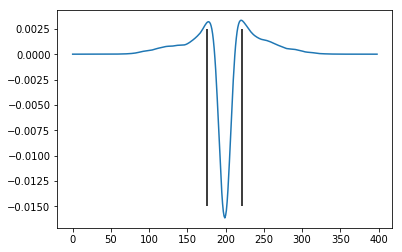

In [21]:
plt.plot(rf_model(0.5, 0.5))
plt.vlines(176, -0.015, 0.0025)
plt.vlines(222, -0.015, 0.0025)

In [34]:
t = scipy.linalg.toeplitz(np.zeros(400), r=rf_model(0.5, 0.5))
t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_model(0.5, 0.5)[::-1])
t2 = t_rev[::-1, ::-1]

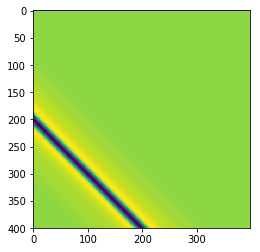

In [35]:
plt.imshow(t2)

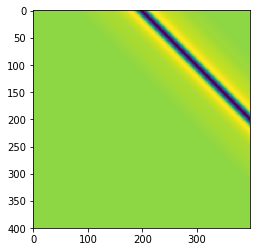

In [23]:
plt.imshow(t)

In [40]:
filters = np.vstack([t2, t])[200:-200]

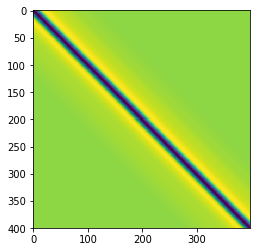

In [41]:
plt.imshow(filters)

In [53]:
filters_sparse = filters[25:-25:50]

In [54]:
filters_sparse.shape

(7, 399)

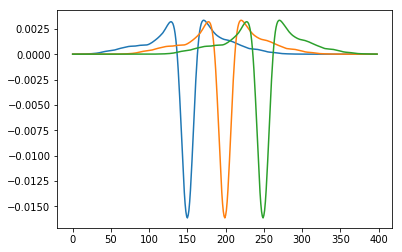

In [55]:
plt.plot(filters[150])
plt.plot(filters[200])
plt.plot(filters[250])

In [56]:
sigma_f = np.cov(filters_sparse)

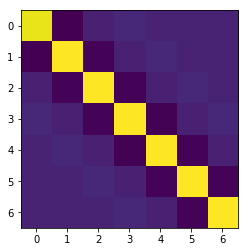

In [57]:
plt.imshow(sigma_f)

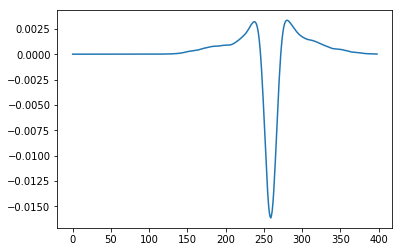

In [31]:
plt.plot(t[60])

In [78]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [79]:
f = filter_bank([0.2, 0.5], [0.6, 0.5])

In [80]:
f.shape

(14, 399)

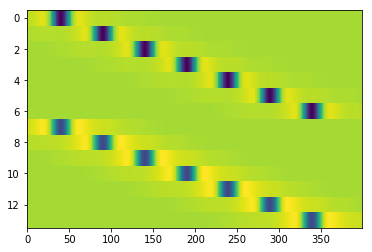

In [81]:
plt.imshow(f, aspect='auto')

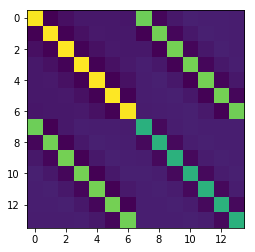

In [83]:
plt.imshow(np.cov(f))

In [90]:
f.shape

(14, 399)

In [91]:
spatial_signals = generate_spatial_signals(1000)
spatial_signals.shape

(1000, 398)

In [95]:
np.cov(np.dot(f[:, :-1], spatial_signals.T)).shape

(14, 14)

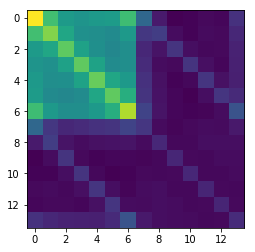

In [96]:
plt.imshow(np.cov(np.dot(f[:, :-1], spatial_signals.T)))

In [108]:
sigma_s = np.cov(np.dot(f[:, :-1], spatial_signals.T))
sigma_n = np.cov(f)

In [109]:
sigma_t = sigma_s + sigma_n

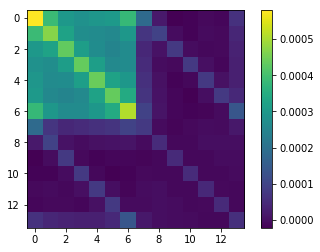

In [110]:
plt.imshow(sigma_t)
plt.colorbar()

In [111]:
chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(sigma_t))))
chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(sigma_n))))

In [112]:
chol_t

-77.127643867654484

In [113]:
chol_n

-96.296504612616431

In [114]:
chol_t - chol_n

19.168860744961947

In [115]:
? scipy.optimize.minimize

In [120]:
def mutual_information(hws, cws, samples=1000, target_snr=7.5, input_noise=0.1, output_noise=0.3):
    '''Mutual information between a spatial signal and the output of a bank of filters.
    
    Args:
        hws: horizontal weightings for the filter bank.
        cws: center weightings for the filter bank.
        samples: number of observations to generate.
        target_snr: signal-to-noise ratio to constrain the filter banks.
    Returns:
        info: Mutual information between x and y in nats.
    '''
    spatial_signals = generate_spatial_signals(samples)
    filters = filter_bank(hws, cws)
    sigma_f = np.cov(filters)
    sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
    
    def sigmas(filter_constants, return_snr=False):
        ff_const = np.outer(filter_constants, filter_constants)
        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n
        
        signal_var = np.diag(sigma_signal)
        noise_var = np.diag(sigma_n)
        snr = signal_var/noise_var
        if return_snr:
            return snr
        else:
            return sigma_t, sigma_n
        
    def mse(filter_constants):
        snr = sigmas(filter_constants, return_snr=True)
        return np.mean((snr - target_snr)**2)
    
    res = scipy.optimize.minimize(mse, np.random.rand(sigma_f.shape[0], 1))
    opt_filter_const = res.x
    
    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    return 0.5 * (chol_t - chol_n)

In [133]:
mi = mutual_information([0.5], [1.0])

In [134]:
mi

11.371541023160821

In [148]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        hws = [hw]
        cws = [cw]
        samples = 1000
        target_snr = 10.5
        input_noise = 0.1
        output_noise = 0.35
        spatial_signals = generate_spatial_signals(samples)
        filters = filter_bank(hws, cws)
        sigma_f = np.cov(filters)
        sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))

        def sigmas(filter_constants, return_snr=False):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_snr:
                return snr
            else:
                return sigma_t, sigma_n

        def mse(filter_constants):
            snr = sigmas(filter_constants, return_snr=True)
            return np.mean((snr - target_snr)**2)

        res = scipy.optimize.minimize(mse, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = res.x

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi


0it [00:00, ?it/s]
1it [00:04,  4.73s/it]
20it [01:31,  4.50s/it]


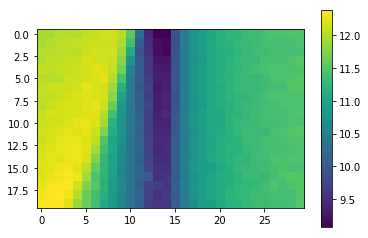

In [151]:
plt.imshow(info_map[:20, :30])
plt.colorbar()

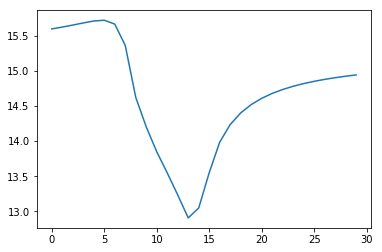

In [215]:
plt.plot(info_map[:20, :30][10])

In [221]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
# target_power = 48.053365503112332 #54.131410989171826
target_power = 100.
target_snr = 0.5

In [195]:
old_info_map = info_map

In [222]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [229]:
opt_filter_const.shape

(7,)

In [228]:
filters.shape

(7, 399)

In [233]:
(filters.T * opt_filter_const).T

(7, 399)

In [238]:
(np.dot((filters.T * opt_filter_const).T, (filters.T * opt_filter_const)))

array([[  2.48243046e-004,   7.26720132e-009,   1.90912053e-022,
          4.24544234e-045,   4.23904261e-076,   1.08270742e-116,
          2.32805720e-166],
       [  7.26720132e-009,   2.45295605e-004,   7.42999287e-009,
          1.90506795e-022,   1.44494439e-044,   4.25526821e-076,
          1.05497446e-116],
       [  1.90912053e-022,   7.42999287e-009,   2.59489329e-004,
          7.67138982e-009,   4.41988060e-022,   1.50078617e-044,
          4.29008898e-076],
       [  4.24544234e-045,   1.90506795e-022,   7.67138982e-009,
          2.61493607e-004,   1.14444094e-008,   4.48057903e-022,
          1.47677420e-044],
       [  4.23904261e-076,   1.44494439e-044,   4.41988060e-022,
          1.14444094e-008,   2.52760732e-004,   7.51702832e-009,
          1.88201018e-022],
       [  1.08270742e-116,   4.25526821e-076,   1.50078617e-044,
          4.48057903e-022,   7.51702832e-009,   2.57759833e-004,
          7.44086624e-009],
       [  2.32805720e-166,   1.05497446e-116,   4.29

In [240]:
residual = (np.outer(opt_filter_const, opt_filter_const) * np.dot(filters, filters.T)) - (
    np.dot((filters.T * opt_filter_const).T, (filters.T * opt_filter_const)))

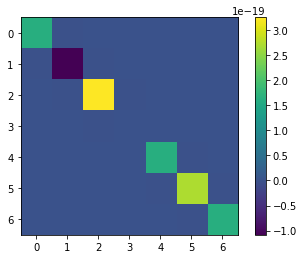

In [242]:
plt.imshow(residual)
plt.colorbar()

In [244]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
samples = 1000
spatial_signals = generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        hws = [hw]
        cws = [cw]
        filters = filter_bank(hws, cws)
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            normed_filters = (filters.T * filter_constants).T
            sigma_f = np.dot(normed_filters, normed_filters.T)
            fs = np.dot(normed_filters[:, :-1], spatial_signals.T)
            sigma_s = np.dot(fs, fs.T)
            sigma_n = input_noise**2 * sigma_f + output_noise**2
            sigma_signal = sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_snr, 10.9 * np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

20it [07:23, 22.19s/it]


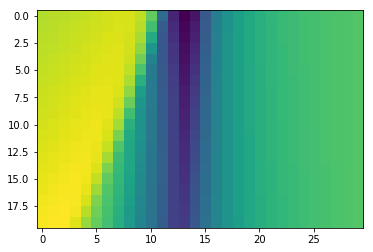

In [245]:
plt.imshow(info_map)

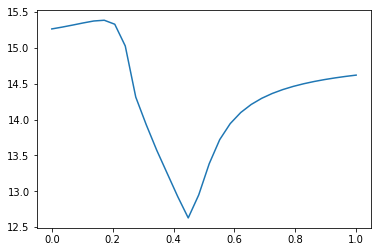

In [246]:
plt.plot(all_cws, info_map[10])

In [208]:
opt_filter_const

array([ 0.26524031,  0.26468666,  0.26464395,  0.26577139,  0.26682344,
        0.26668593,  0.2666665 ,  0.26680907,  0.26746812,  0.26836537,
        0.2681388 ,  0.26698288,  0.26549933,  0.26370305,  0.26200921,
        0.26105021,  0.26125551,  0.2611477 ,  0.26059371,  0.26171866,
        0.26283978,  0.26325091,  0.26560934,  0.26787841,  0.26776197,
        0.2672891 ,  0.26826093,  0.26971129,  0.27065419,  0.27046716,
        0.26911687,  0.2675315 ,  0.26616221])

In [209]:
filters.shape

(33, 399)

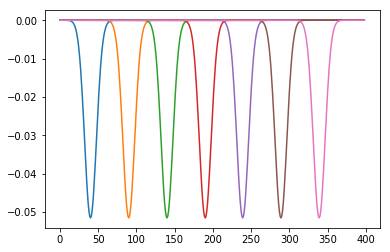

In [220]:
plt.plot(filters.T);

In [217]:
chol_t

3.2812191530202504

In [218]:
chol_n

-26.600321246701611

In [248]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
target_power = 48.053365503112332 #54.131410989171826
# target_power = 100.
# target_snr = 0.5

In [266]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
snr_map = np.zeros((20, 30))
spatial_signals = 10. * generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        snr = sigmas(opt_filter_const, return_flag='snr')
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi
        snr_map[idh, idc] = np.mean(snr)

20it [00:20,  1.04s/it]


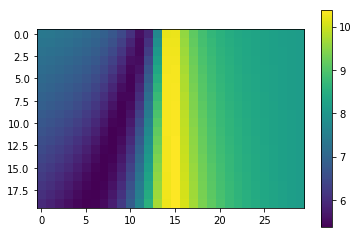

In [274]:
plt.imshow(info_map)
plt.colorbar()

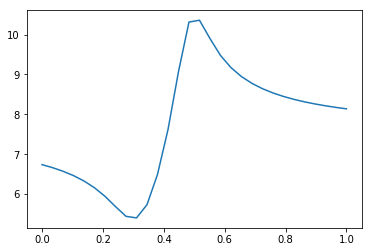

In [269]:
plt.plot(all_cws, info_map[10])

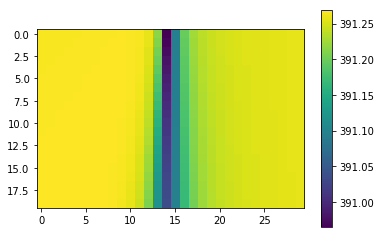

In [271]:
plt.imshow(snr_map)
plt.colorbar()

In [272]:
filters = filter_bank([0.5], [0.7])

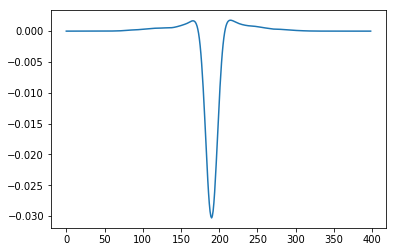

In [273]:
plt.plot(filters[3])

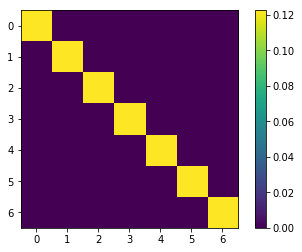

In [278]:
plt.imshow(sigma_n)
plt.colorbar()

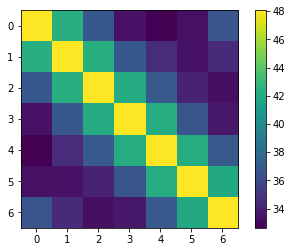

In [277]:
plt.imshow(sigma_t)
plt.colorbar()

In [279]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
snr_map = np.zeros((20, 30))
spatial_signals = 10. * generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
#             sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            nn = input_noise**2 * np.eye(filters.shape[-1])
            fn = np.dot(np.dot(filters, nn), filters.T)
            sigma_n = fn + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        snr = sigmas(opt_filter_const, return_flag='snr')
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi
        snr_map[idh, idc] = np.mean(snr)

20it [02:18,  6.49s/it]


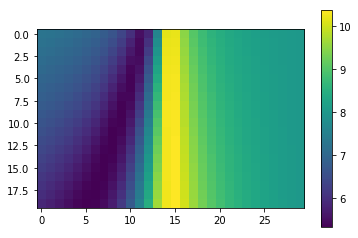

In [280]:
plt.imshow(info_map)
plt.colorbar()

# Okay we've settled on the following:

In [281]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [282]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
target_power = 48.053365503112332 #54.131410989171826
# target_power = 100.
# target_snr = 0.5

In [285]:
hw_res = 60
cw_res = 80
all_hws = np.linspace(0, 1, hw_res)
all_cws = np.linspace(0, 1, cw_res)
info_map = np.zeros((hw_res, cw_res))
spatial_signals = generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

60it [01:43,  1.79s/it]


(0, 1)

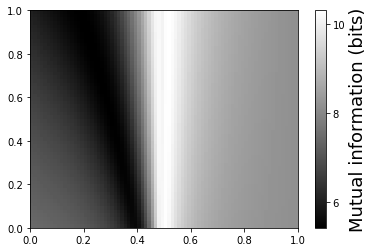

In [290]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])